In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import os
from torchvision import transforms
from PIL import Image
import torch
import cv2
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

from src.Models import (CancerClassifierResNet18, CancerClassifierResNet50, TimmEfficientNet, 
                        CancerClassifierCoaTLiteTiny, CancerClassifierSwinTiny, CancerClassifierConvNeXTTiny)


In [27]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_DIR = Path("/media/lak_05/Windows-SSD/ML/PathoDetect/Data/test")
CSV_PATH = Path("/media/lak_05/Windows-SSD/ML/PathoDetect/Data/test_labels.csv")

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

def load_image(img_path):
    image = Image.open(img_path).convert("RGB")
    tensor = transform(image).to(DEVICE)
    return image, tensor

def load_model(cls, weights_path):
    model = cls()
    checkpoint = torch.load(weights_path, map_location=DEVICE, weights_only=False)
    state_dict = {k.replace("base_model.", "base."): v for k, v in checkpoint["model_state"].items()}
    model.load_state_dict(state_dict)
    model.to(DEVICE).eval()
    return model

def load_effnet_model(weights_path):
    model = TimmEfficientNet()
    if weights_path is not None:
        checkpoint = torch.load(weights_path, map_location=DEVICE, weights_only=False)
        if "model_state" in checkpoint:
            model.load_state_dict(checkpoint["model_state"])
        else:
            model.load_state_dict(checkpoint)
    model.to(DEVICE).eval()
    return model

def load_transformer_model(cls, weights_path):
    model = cls(pretrained=False)
    checkpoint = torch.load(weights_path, map_location=DEVICE, weights_only=False)
    if "model_state" in checkpoint:
        model.load_state_dict(checkpoint["model_state"])
    else:
        model.load_state_dict(checkpoint)
    model.to(DEVICE).eval()
    return model

df = pd.read_csv(CSV_PATH)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

def get_image_tensor_and_label(row):
    img_path = os.path.join(IMG_DIR, row["filename"])
    label = int(row["label"])

    img = Image.open(img_path).convert("RGB")
    image_tensor = transform(img).unsqueeze(0).to(DEVICE)

    return image_tensor, label

MODELS = {
    "ResNet18": {
        "model": lambda: load_model(CancerClassifierResNet18, "/media/lak_05/Windows-SSD/ML/PathoDetect/Final_Models/ResNet18.pth"),
        "target_layer": lambda model: model.base.layer4[-1],
        "threshold": 0.23
    },
    "ResNet50": {
        "model": lambda: load_model(CancerClassifierResNet50, "/media/lak_05/Windows-SSD/ML/PathoDetect/Final_Models/ResNet50.pth"),
        "target_layer": lambda model: model.base.layer4[-1],
        "threshold": 0.35
    },
    "EffNetB0": {
        "model": lambda: load_effnet_model("/media/lak_05/Windows-SSD/ML/PathoDetect/Final_Models/EfficientNetB0.pth"),
        "target_layer": lambda model: model.backbone.conv_head,
        "threshold": 0.35
    },
    "CoaTLiteTiny": {
    "model": lambda: load_transformer_model(
        CancerClassifierCoaTLiteTiny,
        "/media/lak_05/Windows-SSD/ML/PathoDetect/Final_Models/CoaTLite.pth"
    ),
    "target_layer": lambda model: model.base_model.serial_blocks4[-1].factoratt_crpe, 
    "threshold": 0.19
    },
    "SwinTiny": {
        "model": lambda: load_transformer_model(CancerClassifierSwinTiny, "/media/lak_05/Windows-SSD/ML/PathoDetect/Final_Models/SwinTiny.pth"),
        "target_layer": lambda model: model.base_model.layers[3].blocks[1].norm1,
        "threshold": 0.33
    },
    "ConvNeXTTiny": {
    "model": lambda: load_transformer_model(
        CancerClassifierConvNeXTTiny,
        "/media/lak_05/Windows-SSD/ML/PathoDetect/Final_Models/ConvNext.pth"
    ),
    "target_layer": lambda model: model.base_model.stages[-1].blocks[-1].conv_dw,
    "threshold": 0.20
}
}

In [29]:
def compute_gradcam(model, input_tensor, target_layer, threshold=0.5):
    activations, gradients = [], []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks
    fwd_handle = target_layer.register_forward_hook(forward_hook)
    bwd_handle = target_layer.register_full_backward_hook(backward_hook)

    # Inference
    input_tensor = input_tensor.unsqueeze(0)
    output = model(input_tensor)
    confidence = torch.sigmoid(output).item()
    pred_label = int(confidence >= threshold)

    model.zero_grad()
    output.backward()

    # GradCAM calc
    act = activations[0].detach()
    grad = gradients[0].detach()
    pooled_grads = torch.mean(grad, dim=[0, 2, 3])
    for i in range(act.shape[1]):
        act[:, i, :, :] *= pooled_grads[i]

    heatmap = torch.mean(act, dim=1).squeeze()
    heatmap = F.relu(heatmap)
    heatmap /= heatmap.max() + 1e-8
    heatmap = heatmap.cpu().numpy()

    fwd_handle.remove()
    bwd_handle.remove()

    return heatmap, confidence, pred_label

def plot_gradcam_with_conf(image_pil, heatmap, confidence, pred_label, true_label=None, title="GradCAM"):
    image_np = np.array(image_pil.resize((224, 224))) / 255.0
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_TURBO)
    overlay = cv2.addWeighted(np.uint8(image_np * 255), 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(5, 5))
    plt.imshow(overlay)
    
    label_str = "Cancerous" if pred_label else "Non-Cancerous"
    gt_str = f"GT: {true_label} | " if true_label is not None else ""
    plt.title(f"{gt_str}Pred: {label_str} ({confidence*100:.2f}% conf)", fontsize=11)
    plt.axis("off")
    plt.show()

In [ ]:
def run_gradcam_for_model(model_name):
    config = MODELS[model_name]
    model = config["model"]()
    target_layer = config["target_layer"](model)
    threshold = config["threshold"]

    df = pd.read_csv(CSV_PATH).sample(n=12, random_state=777)
    results = []

    for idx, row in df.iterrows():
        fname = row['filename']
        true_label = row['label']
        img_path = IMG_DIR / fname

        try:
            image_pil, tensor = load_image(img_path)

            if "CoaT" in model_name or "Swin" in model_name:
                heatmap, confidence, pred_label = compute_transformer_gradcam(
                    model, tensor, target_layer, threshold=threshold
                )
            else:
                heatmap, confidence, pred_label = compute_gradcam(
                    model, tensor, target_layer, threshold=threshold
                )

            image_np = np.array(image_pil.resize((224, 224))) / 255.0
            heatmap_resized = cv2.resize(heatmap, (224, 224))
            heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_TURBO)
            overlay = cv2.addWeighted(np.uint8(image_np * 255), 0.6, heatmap_color, 0.4, 0)

            results.append((overlay, confidence, pred_label, true_label))

        except Exception as e:
            print(f"❌ Error processing {fname}: {e}")

    # --- Display all results in a grid ---
    cols = 4
    rows = (len(results) + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))

    for i, (overlay, conf, pred, true) in enumerate(results):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(overlay)
        pred_str = "Cancerous" if pred else "Non-Cancerous"
        color = 'green' if pred == true else 'red'
        plt.title(f"{pred_str}\n{conf*100:.1f}% | GT: {true}", fontsize=10, color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.suptitle(f"Grad-CAM for {model_name}", fontsize=16)
    plt.subplots_adjust(top=0.90)
    plt.show()

def compute_transformer_gradcam(model, input_tensor, target_layer, threshold=0.5):
    activations, gradients = [], []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    fwd_handle = target_layer.register_forward_hook(forward_hook)
    bwd_handle = target_layer.register_full_backward_hook(backward_hook)

    output = model(input_tensor.unsqueeze(0))  # input_tensorr is (3, 224, 224)
    confidence = torch.sigmoid(output).item()
    pred_label = int(confidence >= threshold)

    model.zero_grad()
    output.backward()

    act = activations[0].detach()
    grad = gradients[0].detach()

    if act.ndim == 4:  # CNN-like: [B, C, H, W]
        weights = grad.mean(dim=(2, 3), keepdim=True)  # /Global average pooling
        cam = (weights * act).sum(dim=1, keepdim=True)  # [B, 1, H, W]
        cam = F.relu(cam).squeeze().cpu().numpy()
        cam = cam / (cam.max() + 1e-8)
    elif act.ndim == 3:  # Transformer-like: [B, L, C]
        weights = grad.mean(dim=1, keepdim=True)  # [B, 1, C]
        cam = (weights * act).sum(dim=-1)         # [B, L]
        cam = F.relu(cam).squeeze()
        cam = cam / (cam.max() + 1e-8)
        num_tokens = cam.numel()
        side = int(num_tokens ** 0.5)
        cam = cam[:side * side].reshape(side, side).cpu().numpy()
    else:
        raise ValueError(f"Unsupported activation shape: {act.shape}")

    fwd_handle.remove()
    bwd_handle.remove()

    return cam, confidence, pred_label

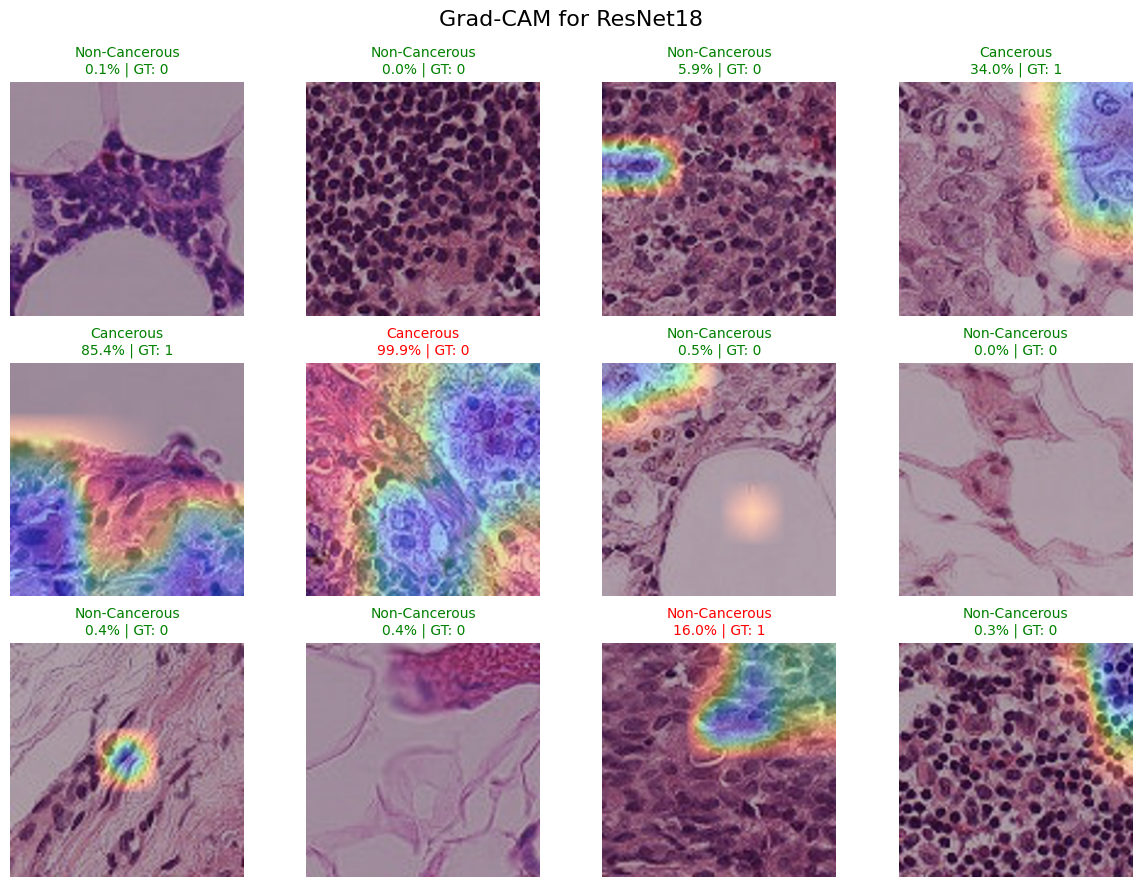

In [32]:
run_gradcam_for_model("ResNet18")

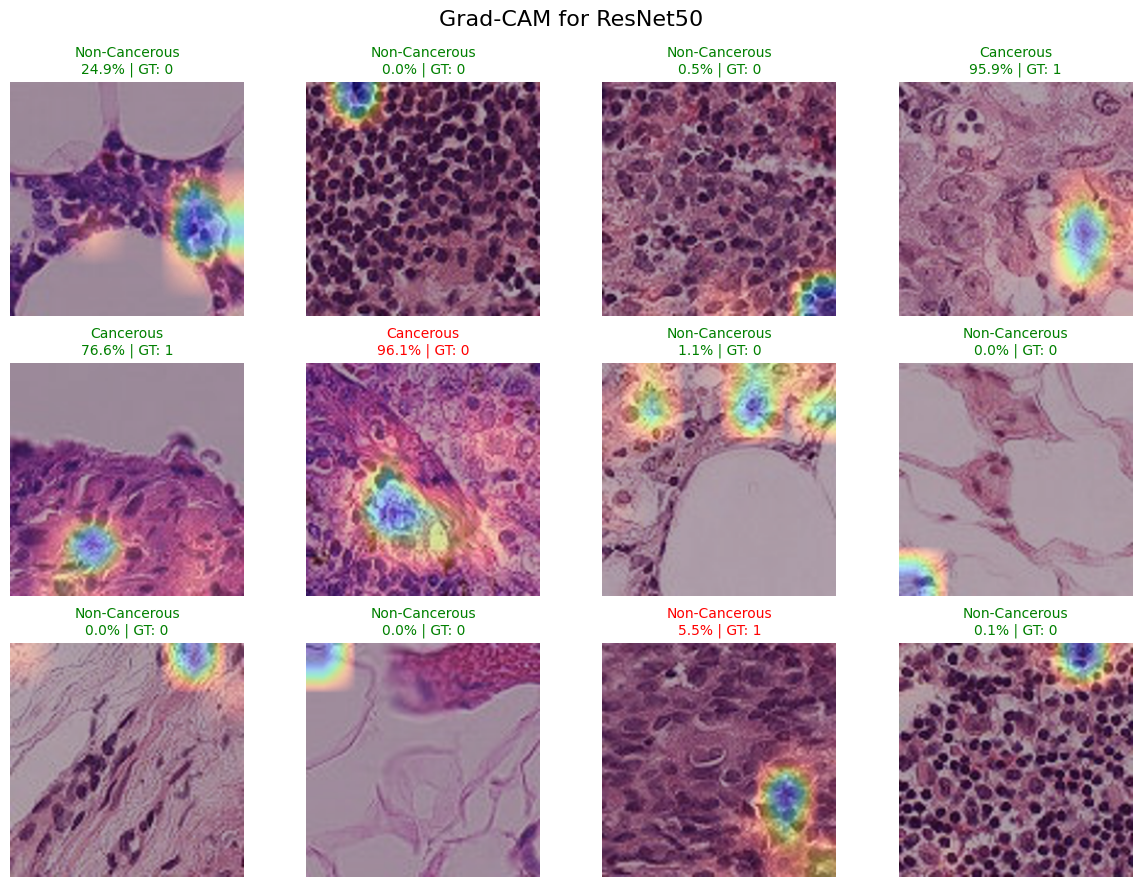

In [33]:
run_gradcam_for_model("ResNet50")

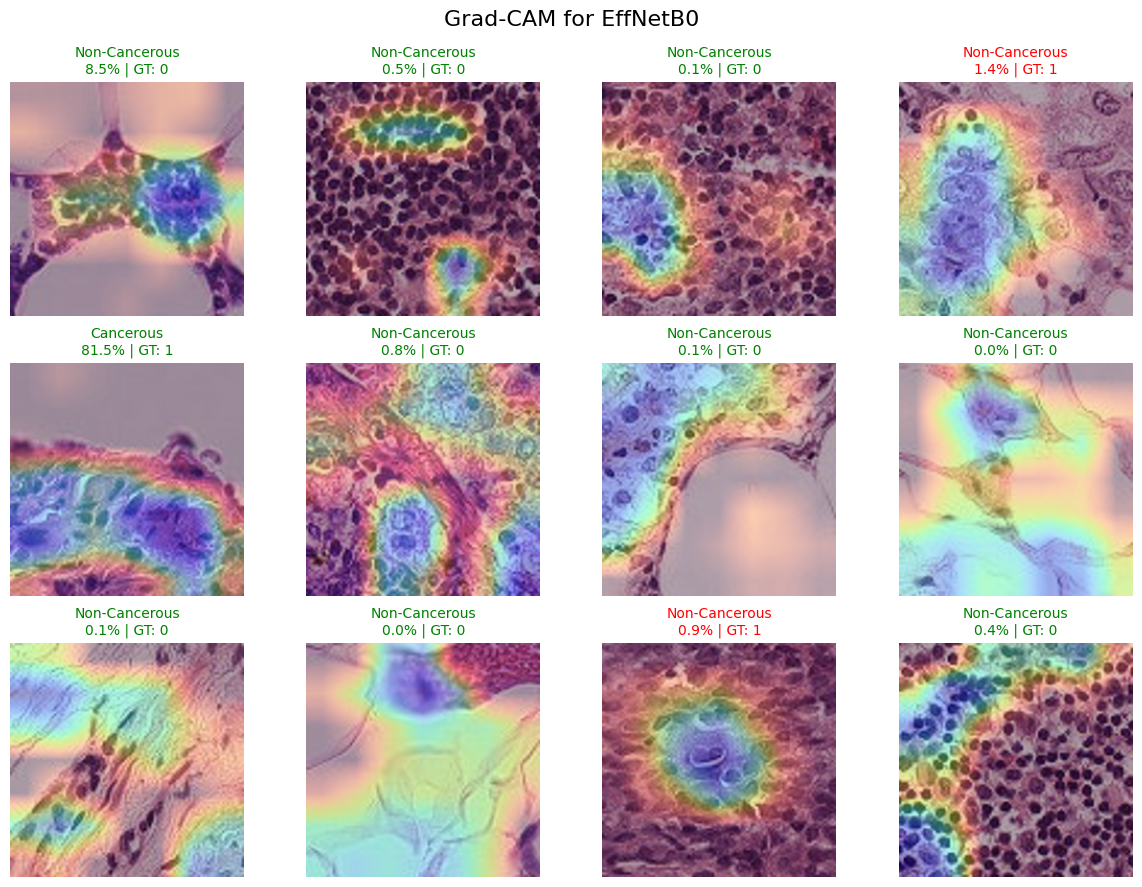

In [34]:
run_gradcam_for_model("EffNetB0")

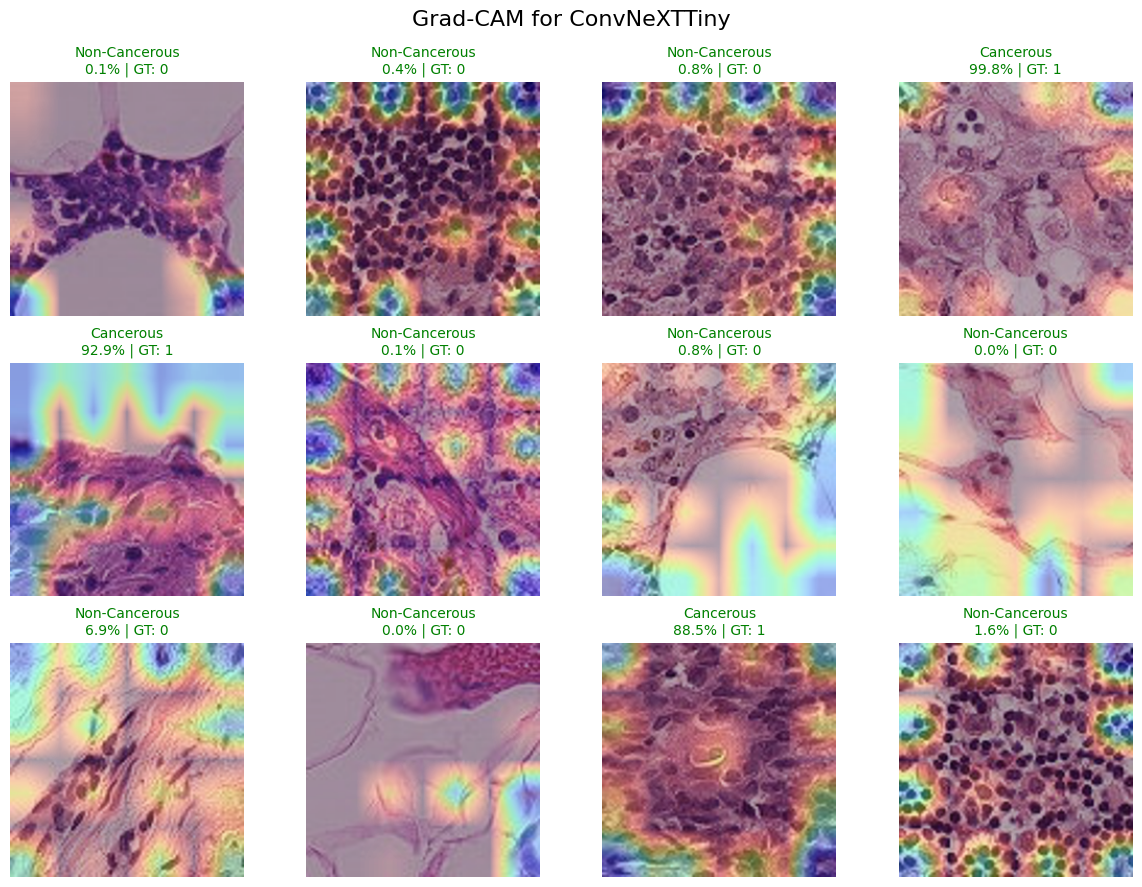

In [35]:
run_gradcam_for_model("ConvNeXTTiny")

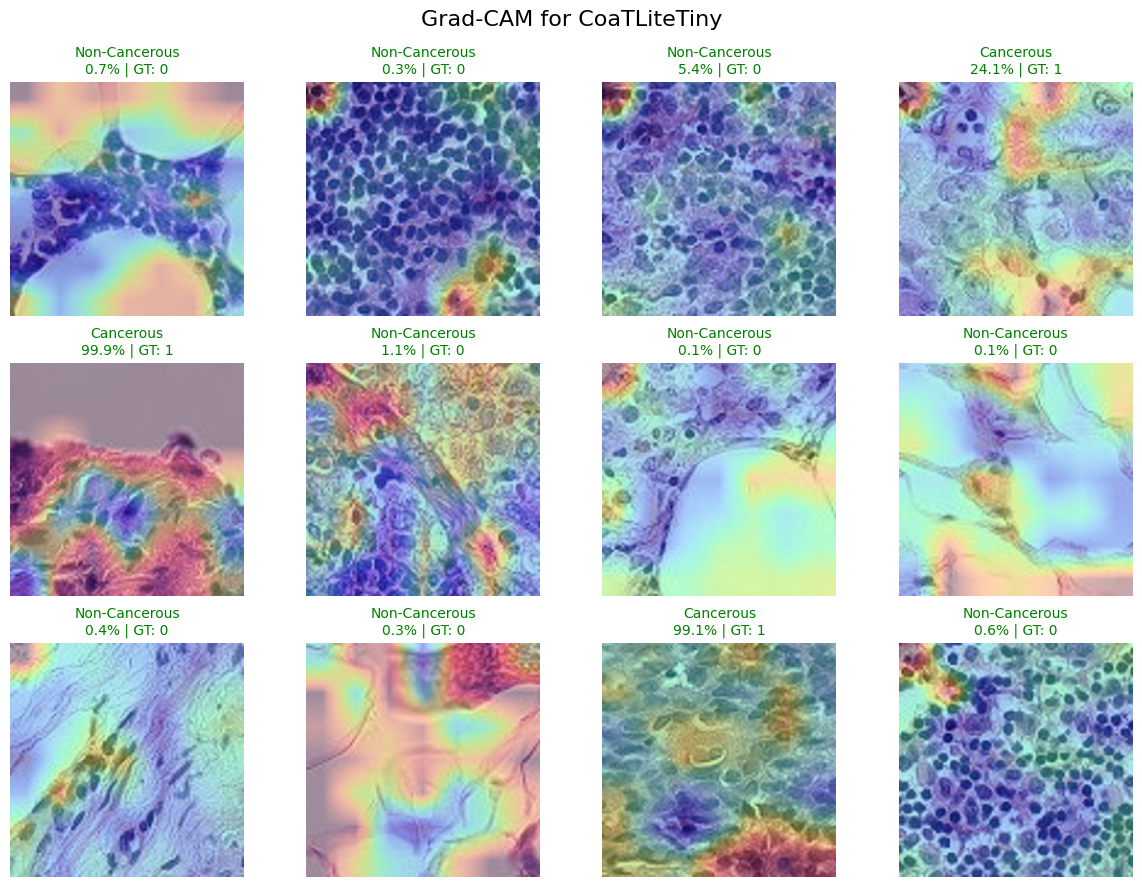

In [36]:
run_gradcam_for_model("CoaTLiteTiny")


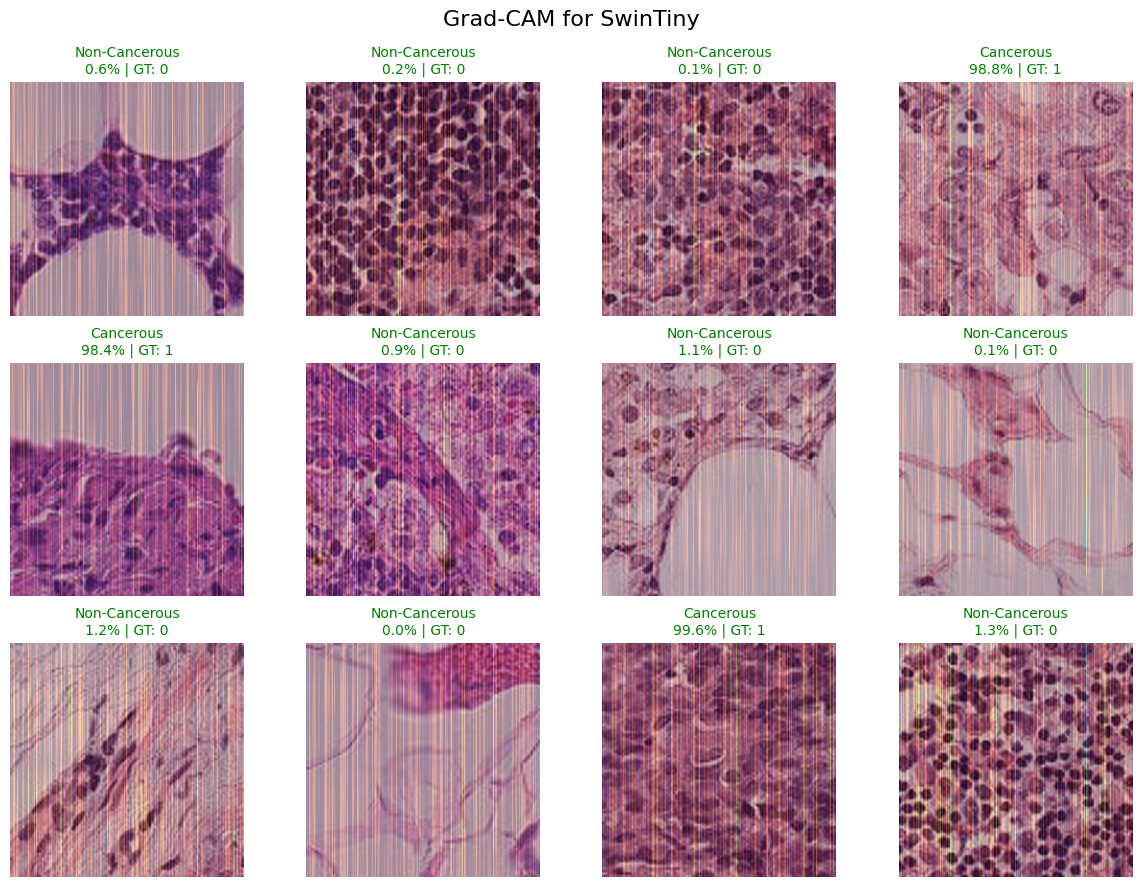

In [37]:
run_gradcam_for_model("SwinTiny")